In [25]:
#
# Working through the example from
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/examples/Ex_7_concentration_input.py
# with the following variation of data:
#
# Take the data data_sets/Ex1_C_data.txt which has A, B, C concentration at all times and
# create a data set which keeps A concentration at every 10th point, B concentration at every 5th point and
# C data at every 30th point. It is stored in data_sets/Ex_1_C_data_irreg.txt
#

In [26]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd

In [27]:
#
# adapted the function read_concetration_data_from_txt at
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/library/data_tools.py
# to allow reading data where all species concentration are not available at all times
#
def read_concentration_data_txt_irreg(filename):
    f = open(filename,'r')
    data_dict = dict()
    set_index = set()
    set_columns = set()

    for line in f:
        if line not in ['','\n','\t','\t\n']:
            l=line.split()
            i = float(l[0])
            j = l[1]
            k = float(l[2])
            set_index.add(i)
            set_columns.add(j)
            data_dict[i,j] = k
    f.close()

    data_array = np.zeros((len(set_index),len(set_columns)))
    data_array.fill(np.nan)

    sorted_index = sorted(set_index)
    sorted_columns = set_columns

    for i,idx in enumerate(sorted_index):
        for j,jdx in enumerate(sorted_columns):
            if (idx, jdx) in data_dict:
                data_array[i,j] = data_dict[idx,jdx]

    return pd.DataFrame(data=data_array,columns=sorted_columns,index=sorted_index)

In [28]:
filename = '../data_sets/Ex_1_C_data_irreg.txt'
C_frame = read_concentration_data_txt_irreg(filename)

In [29]:
C_frame.iloc[:20]

,C,B,A
0.0000,0.000013,0.000000,0.001027
0.1667,NaN,0.000041,NaN
0.3334,NaN,0.000081,0.000928
0.5001,NaN,0.000103,NaN
0.6668,NaN,0.000127,0.000847
0.8335,NaN,0.000132,NaN
1.0002,0.000069,0.000144,0.000788
1.1669,NaN,0.000147,NaN
1.3336,NaN,0.000148,0.000733
1.5003,NaN,0.000146,NaN


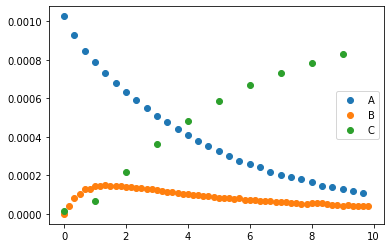

In [30]:
fig, ax = plt.subplots()
ax.scatter(C_frame.index, C_frame['A'], label = 'A')
ax.scatter(C_frame.index, C_frame['B'], label = 'B')
ax.scatter(C_frame.index, C_frame['C'], label = 'C')
ax.legend()

In [31]:
builder = TemplateBuilder()    
components = {'A':1e-3,'B':0,'C':0}
builder.add_mixture_component(components)
builder.add_parameter('k1',bounds=(0.0,5.0))
builder.add_parameter('k2',bounds=(0.0,1.0))
builder.add_concentration_data(C_frame)

Warning! Since {label}-matrix contains negative values Kipet is assuming a derivative of {label} has been inputted


In [32]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']
    return exprs
    
builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,10.0)

initial values: 0.0, C
initial values: 0.0, B
initial values: 0.0, A


In [33]:
sigmas = {'A':1e-10,'B':1e-11,'C':1e-10}

In [34]:
# and define our parameter estimation problem and discretization strategy
p_estimator = ParameterEstimator(opt_model)
p_estimator.apply_discretization('dae.collocation',nfe=60,ncp=3,scheme='LAGRANGE-RADAU')

In [35]:
# Again we provide options for the solver, this time providing the scaling that we set above
options = dict()
#options['nlp_scaling_method'] = 'user-scaling'
options['linear_solver'] = 'ma27'

In [36]:
# finally we run the optimization
results_pyomo = p_estimator.run_opt('ipopt',
                                        variances=sigmas,
                                      tee=True,
                                   solver_opts = options)

Ipopt 3.13.2: linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     4683
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      460

Total number of variables............................:     1085
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1083
T

In [37]:
# And display the results
print("The estimated parameters are:")
for k,v in six.iteritems(results_pyomo.P):
    print(k, v)

The estimated parameters are:
k1 0.22606798023513064
k2 0.9492717221518403


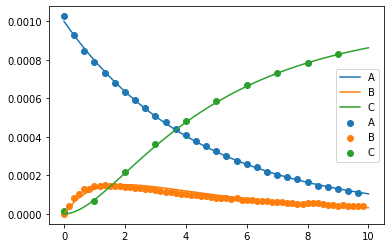

In [44]:
fig, ax = plt.subplots()
for cmp in ['A', 'B', 'C']:
    ax.scatter(results_pyomo.C.index, results_pyomo.C[cmp], label = cmp)
    ax.plot(results_pyomo.Z.index, results_pyomo.Z[cmp], label = cmp)
ax.legend()
plt.show()